![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/b8be43cf89c540bfaf3831f2c8506614).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [171]:
import warnings
warnings.filterwarnings('ignore')

In [209]:
# Importación librerías
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, VotingRegressor 
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [176]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)

In [177]:
# Visualización datos de entrenamiento
dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [178]:
df = dataTraining

# Exploración del set de datos para entrenamiento

In [179]:
lineas= '======================================================='
print(lineas)
print("Registros y columnas del set de datos:")
print(df.shape)
print(lineas)
print("Metadatos del set de datos:")
print(df.info())
print(lineas)
print("Descripción del set de datos:")
print(df.describe())
print(lineas)
print("Validación de datos faltantes en el set de datos")
print(df.isnull().sum().to_frame().rename(columns={0:"Total No. Faltantes"}))
print(lineas)
print("Validación de duplicados en el set de datos")
print("Registros duplicados:",df.duplicated().sum())

Registros y columnas del set de datos:
(400000, 6)
Metadatos del set de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    400000 non-null  int64 
 1   Year     400000 non-null  int64 
 2   Mileage  400000 non-null  int64 
 3   State    400000 non-null  object
 4   Make     400000 non-null  object
 5   Model    400000 non-null  object
dtypes: int64(3), object(3)
memory usage: 18.3+ MB
None
Descripción del set de datos:
               Price           Year       Mileage
count  400000.000000  400000.000000  4.000000e+05
mean    21146.919312    2013.198125  5.507296e+04
std     10753.664940       3.292326  4.088102e+04
min      5001.000000    1997.000000  5.000000e+00
25%     13499.000000    2012.000000  2.584100e+04
50%     18450.000000    2014.000000  4.295500e+04
75%     26999.000000    2016.000000  7.743300e+04
max     79999.000000 

## Resultado del análisis 

Para el entrenamiento del modelo de regresión se nos entrega un set de datos con las isguientes características.

* Set de datos con un total de 400.000 registros y 6 columnas
* Las columnas que contiene el set de datos son las siguientes:

    | Columna | Descripción |
    |---------|-------------|
    | Price | Precio del vehículo |
    | Year | Año de fabricación del vehículo (Modelo) |
    | Mileage | Millas recorridas |
    | State | Estado en el cual se ubica el vehículo |
    | Make | Fabricante del vehículo |
    | Model | Referencia del vehículo para el fabricante |
    
* Dentro del set de datos se tiene vehiculos que van de modelo 1997 hasta 2018, siendo el menor precio de 5.001 y el mayor de 79.999.
* No se encuentra datos faltantes dentro del set de datos para ninguna de las columnas.
* Se evidencia que dentro del set de datos existen 169 registros duplicados los cuales seran eliminados para entrenar el modelo y las respectivas validaciones.



In [180]:
#Eliminar duplicados del set de datos
df.drop_duplicates(inplace=True)
print(df.shape)

(399831, 6)


# Análisis descriptivo del set de datos

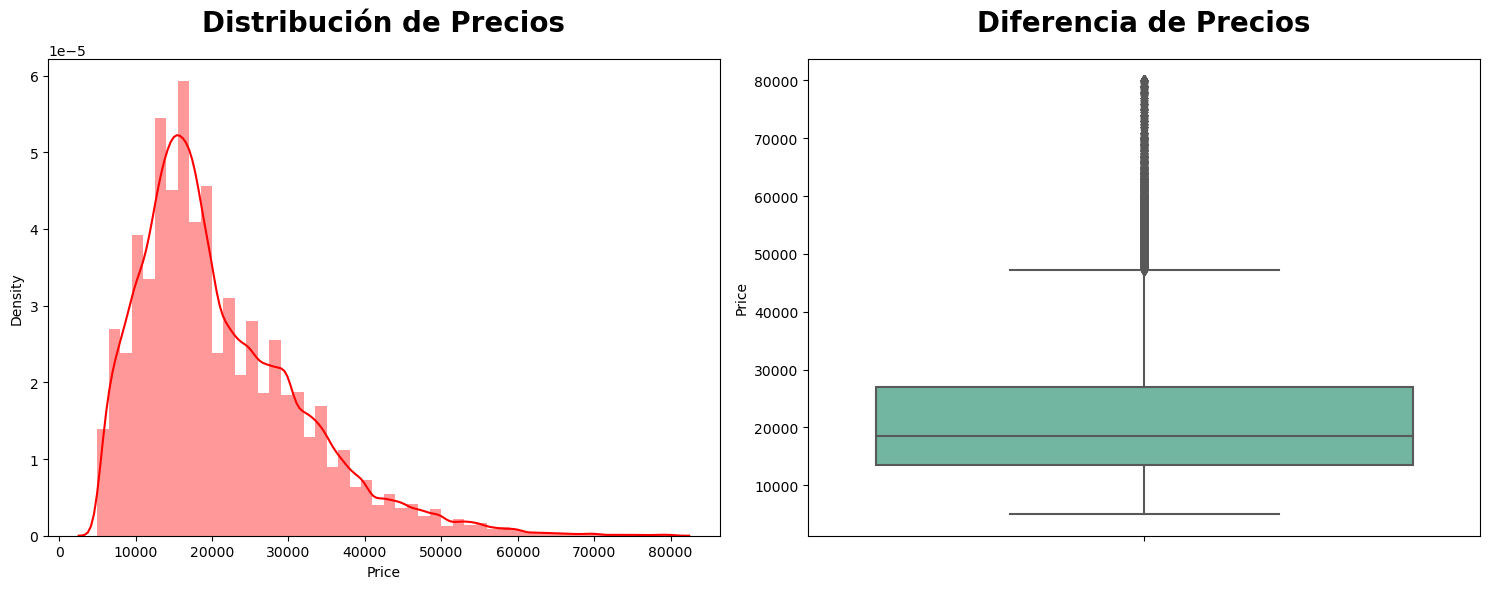

,min,mean,median,max,std,skew
Price,5001.0,21143.998537,18449.0,79999.0,10751.954687,1.188749


In [181]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.distplot(df["Price"],color="red",kde=True)
plt.title("Distribución de Precios",fontweight="black",pad=20,fontsize=20)

plt.subplot(1,2,2)
sns.boxplot(y=df["Price"],palette="Set2")
plt.title("Diferencia de Precios",fontweight="black",pad=20,fontsize=20)
plt.tight_layout()
plt.show()

df["Price"].agg(["min","mean","median","max","std","skew"]).to_frame().T

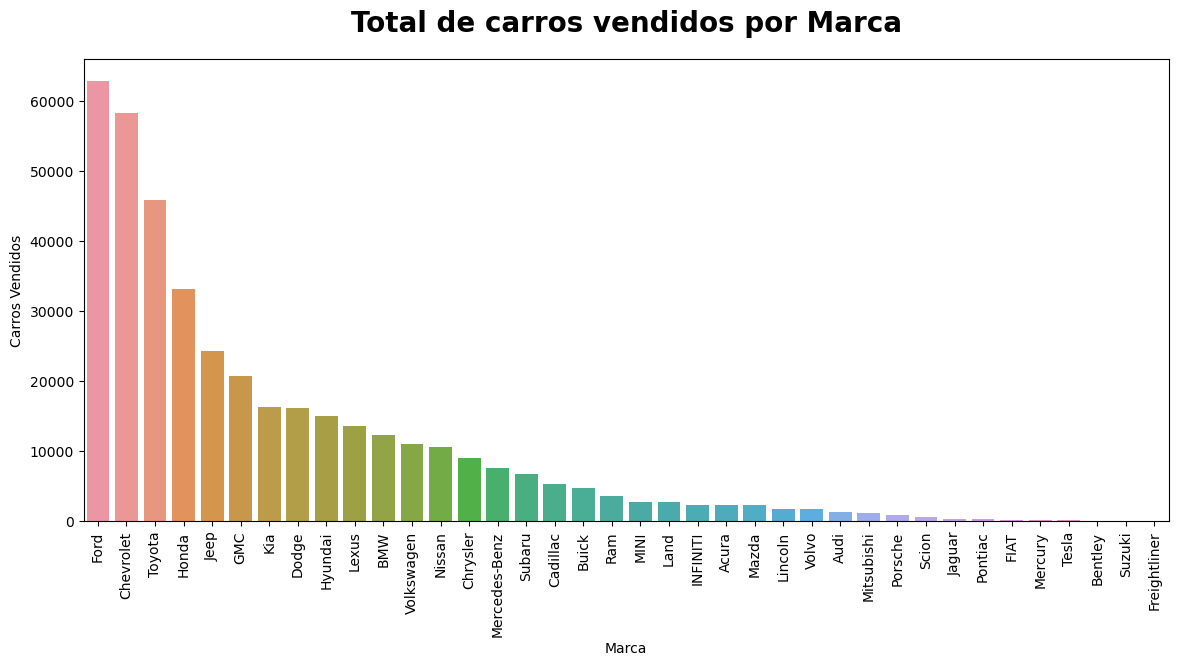

In [182]:
plt.figure(figsize=(14,6))
counts = df["Make"].value_counts()
sns.barplot(x=counts.index, y=counts.values)
plt.xlabel("Marca")
plt.ylabel("Carros Vendidos")
plt.title("Total de carros vendidos por Marca", pad=20, fontweight="black", fontsize=20)
plt.xticks(rotation=90)
plt.show()

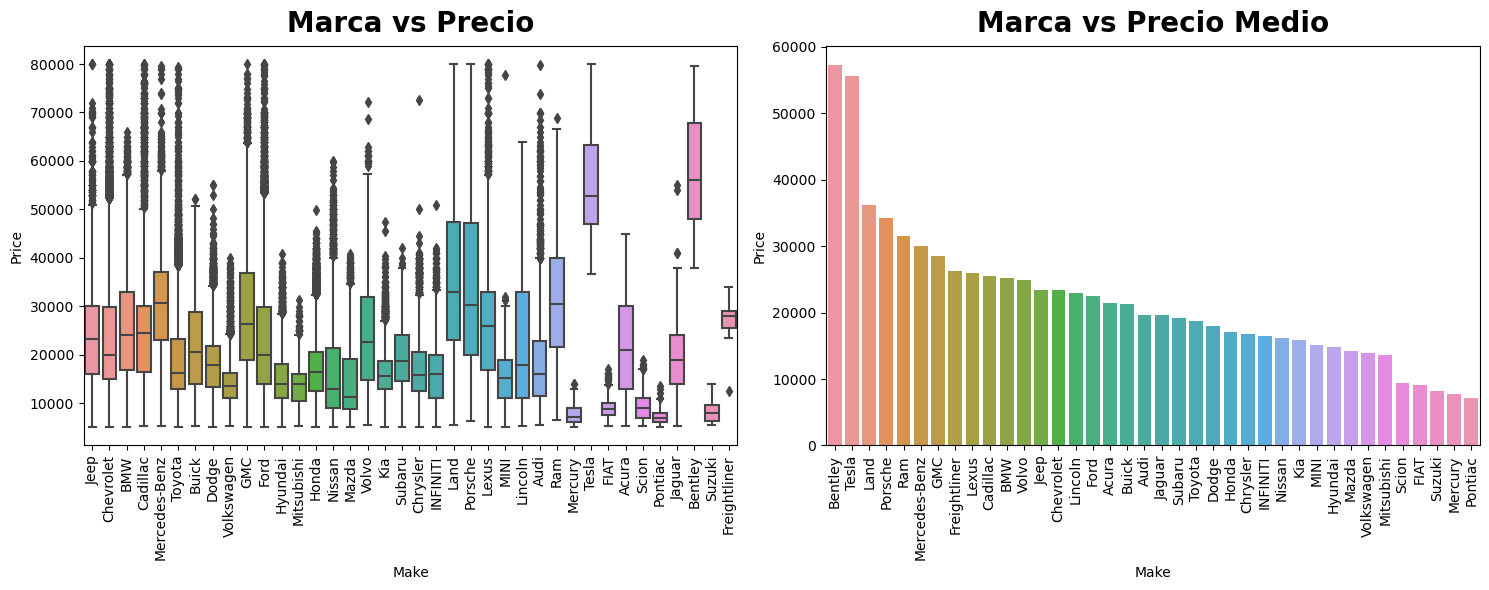

In [183]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.boxplot(x="Make",y="Price",data=df)
plt.xticks(rotation=90)
plt.title("Marca vs Precio", pad=10, fontweight="black", fontsize=20)

plt.subplot(1,2,2)
x = pd.DataFrame(df.groupby("Make")["Price"].mean().sort_values(ascending=False))
sns.barplot(x=x.index,y="Price",data=x) 
plt.xticks(rotation=90)
plt.title("Marca vs Precio Medio", pad=10, fontweight="black", fontsize=20)
plt.tight_layout()
plt.show()

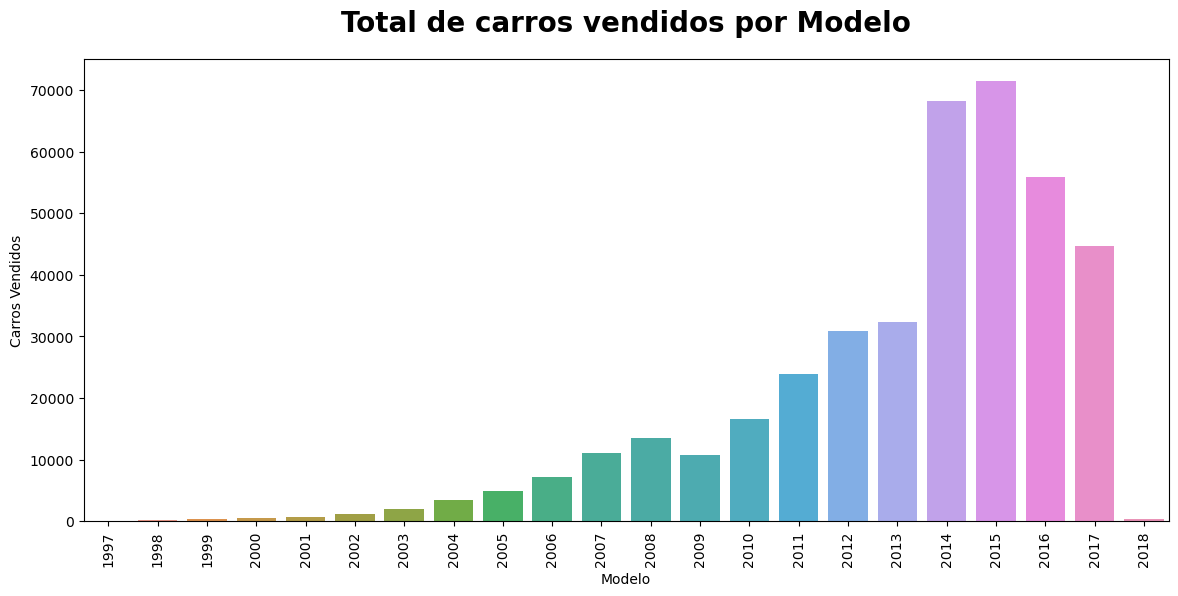

In [184]:
plt.figure(figsize=(14,6))
counts = df["Year"].value_counts()
sns.barplot(x=counts.index, y=counts.values)
plt.xlabel("Modelo")
plt.ylabel("Carros Vendidos")
plt.title("Total de carros vendidos por Modelo", pad=20, fontweight="black", fontsize=20)
plt.xticks(rotation=90)
plt.show()

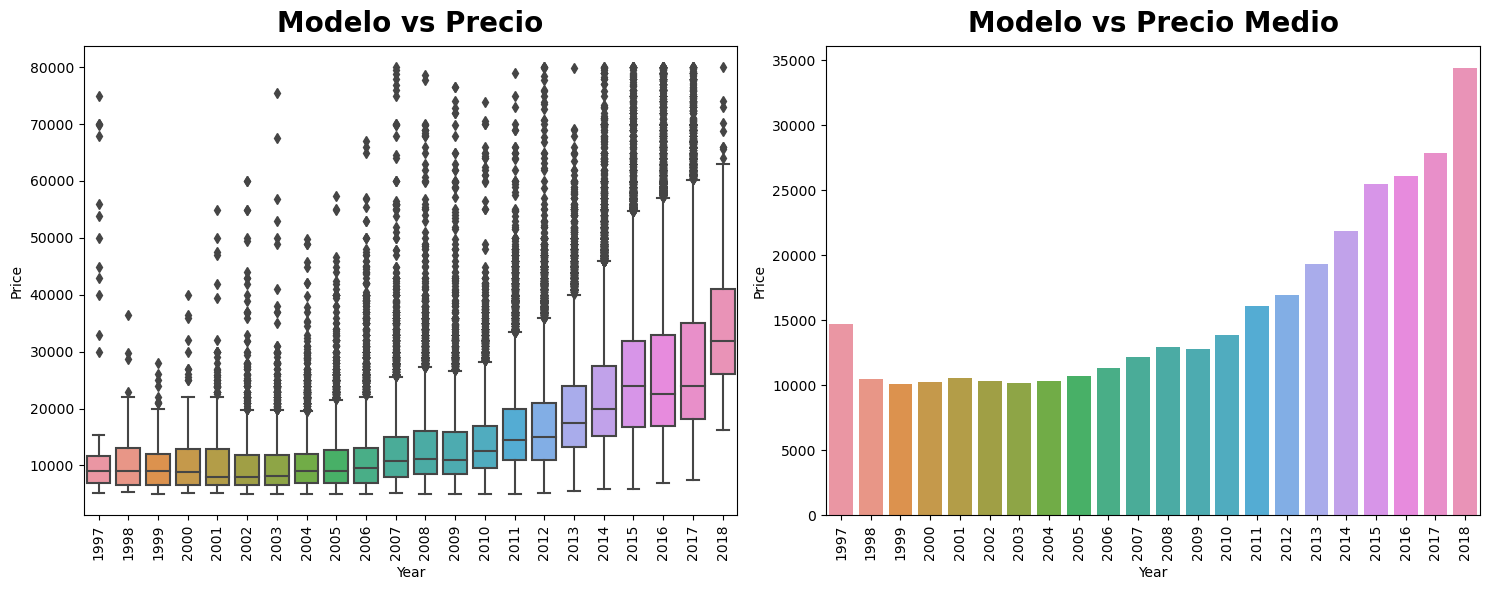

In [185]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.boxplot(x="Year",y="Price",data=df)
plt.xticks(rotation=90)
plt.title("Modelo vs Precio", pad=10, fontweight="black", fontsize=20)

plt.subplot(1,2,2)
x = pd.DataFrame(df.groupby("Year")["Price"].mean().sort_values(ascending=False))
sns.barplot(x=x.index,y="Price",data=x) 
plt.xticks(rotation=90)
plt.title("Modelo vs Precio Medio", pad=10, fontweight="black", fontsize=20)
plt.tight_layout()
plt.show()

## Resultado del análisis 

Luego de hacer el análisis del set de datos 

* Hay una diferencia aproximada de 3000 entre la media y la mediana
* La mayoria de los precios de automoviles estan por debajo de los 18000
* Dentro de la lista se observa que las marcas con mas vehiculos son Ford, Chevrolet y Toyota
* Se puede observar que existen compañias con muy pocos datos como son Tesla y Bentley para lo cual es posible que el modelo no pueda predecir muy bien respecto a estas marcas.
* Existe relación entre el modelo del auto y el valor de venta, a mayor modelo se evidencia que mayor es el precio de venta.


In [186]:
# Separamos la variable objetivo (Price) y las características
X = df.drop('Price', axis=1)
y = df['Price']

# Dividimos el conjunto de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Definimos qué columnas son numéricas y cuáles son categóricas
numeric_features = ['Year', 'Mileage']
categorical_features = ['State', 'Make', 'Model']

# Creamos transformadores para escalar variables numéricas y codificar variables categóricas
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Aplicamos las transformaciones a las columnas correspondientes utilizando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Ajustamos y transformamos el conjunto de entrenamiento
X_train_transformed = preprocessor.fit_transform(X_train)

# Transformamos el conjunto de prueba (no ajustamos para evitar filtración de datos)
X_test_transformed = preprocessor.transform(X_test)

In [187]:
X_Testing_transformed = preprocessor.transform(dataTesting)

In [188]:
n_training=279881
n_test=119950
training_r2 = []
testing_r2 = []
training_rmse = []
testing_rmse = []
training_mae = []
testing_mae = []
training_mape = []
testing_mape = []



def evaluacion_y_prediccion(model):
    model.fit(X_train_transformed,y_train)
    y_train_pred = model.predict(X_train_transformed)
    y_test_pred = model.predict(X_test_transformed)
    a = r2_score(y_train,y_train_pred)*100
    b = r2_score(y_test,y_test_pred)*100
    mse_c = mean_squared_error(y_train, y_train_pred)
    mse_d = mean_squared_error(y_test, y_test_pred)
    rmse_c = np.sqrt(mse_c)
    rmse_d = np.sqrt(mse_d)
    mae_e = (1/n_training) * sum(abs(y_train_pred - y_train))
    mae_f = (1/n_test) * sum(abs(y_test_pred - y_test))
    mape_g = (1/n_training) * sum(abs((y_train - y_train_pred) / y_train)) * 100
    mape_h = (1/n_test) * sum(abs((y_test - y_test_pred) / y_test)) * 100
    
    training_r2.append(a)
    testing_r2.append(b)
    training_rmse.append(rmse_c)
    testing_rmse.append(rmse_d)
    training_mae.append(mae_e)
    testing_mae.append(mae_f)
    training_mape.append(mape_g)
    testing_mape.append(mape_h)
    
    print(f"r2_Score de {model} en datos de Trainig es:",a)
    print(f"r2_Score de {model} en datos de Testing es:",b)
    print(f"rmse_Score de {model} en datos de Trainig es:",rmse_c)
    print(f"rmse_Score de {model} en datos de Testing es:",rmse_d)
    print(f"mae_Score de {model} en datos de Trainig es:",mae_e)
    print(f"mae_Score de {model} en datos de Testing es:",mae_f)
    print(f"mape_Score de {model} en datos de Trainig es:",mape_g)
    print(f"mape_Score de {model} en datos de Testing es:",mape_h)

In [190]:
# 1. Regresion Lineal

evaluacion_y_prediccion(LinearRegression())

r2_Score de LinearRegression() en datos de Trainig es: 83.10562160243414
r2_Score de LinearRegression() en datos de Testing es: 83.16540487334933
rmse_Score de LinearRegression() en datos de Trainig es: 4418.597728930749
rmse_Score de LinearRegression() en datos de Testing es: 4413.25628835872
mae_Score de LinearRegression() en datos de Trainig es: 2972.0088132417873
mae_Score de LinearRegression() en datos de Testing es: 2972.524890402321
mape_Score de LinearRegression() en datos de Trainig es: 16.43620951540401
mape_Score de LinearRegression() en datos de Testing es: 16.40671804438993


In [191]:
# 2. Arbol de decisión

evaluacion_y_prediccion(DecisionTreeRegressor())

r2_Score de DecisionTreeRegressor() en datos de Trainig es: 99.98756518904565
r2_Score de DecisionTreeRegressor() en datos de Testing es: 80.24830427391748
rmse_Score de DecisionTreeRegressor() en datos de Trainig es: 119.87619511914693
rmse_Score de DecisionTreeRegressor() en datos de Testing es: 4780.353398740472
mae_Score de DecisionTreeRegressor() en datos de Trainig es: 2.0156465307279405
mae_Score de DecisionTreeRegressor() en datos de Testing es: 2949.16808357649
mape_Score de DecisionTreeRegressor() en datos de Trainig es: 0.0063979073056449915
mape_Score de DecisionTreeRegressor() en datos de Testing es: 14.421657642771994


In [205]:
# 3. Random Forest

evaluacion_y_prediccion(RandomForestRegressor(max_depth=10, n_estimators=50))


r2_Score de RandomForestRegressor(max_depth=10, n_estimators=50) en datos de Trainig es: 52.9599863899596
r2_Score de RandomForestRegressor(max_depth=10, n_estimators=50) en datos de Testing es: 52.005982550371364
rmse_Score de RandomForestRegressor(max_depth=10, n_estimators=50) en datos de Trainig es: 7373.048246194069
rmse_Score de RandomForestRegressor(max_depth=10, n_estimators=50) en datos de Testing es: 7451.631385162272
mae_Score de RandomForestRegressor(max_depth=10, n_estimators=50) en datos de Trainig es: 5565.157822779395
mae_Score de RandomForestRegressor(max_depth=10, n_estimators=50) en datos de Testing es: 5624.1564202486215
mape_Score de RandomForestRegressor(max_depth=10, n_estimators=50) en datos de Trainig es: 30.117079863120928
mape_Score de RandomForestRegressor(max_depth=10, n_estimators=50) en datos de Testing es: 30.332832090213856


In [206]:
# 4. Gradient Boosting

evaluacion_y_prediccion(GradientBoostingRegressor())

r2_Score de GradientBoostingRegressor() en datos de Trainig es: 61.37378793529009
r2_Score de GradientBoostingRegressor() en datos de Testing es: 61.22250522744515
rmse_Score de GradientBoostingRegressor() en datos de Trainig es: 6681.199141766121
rmse_Score de GradientBoostingRegressor() en datos de Testing es: 6698.039196406893
mae_Score de GradientBoostingRegressor() en datos de Trainig es: 5072.160815592355
mae_Score de GradientBoostingRegressor() en datos de Testing es: 5088.488163000861
mape_Score de GradientBoostingRegressor() en datos de Trainig es: 27.788665049341322
mape_Score de GradientBoostingRegressor() en datos de Testing es: 27.831973845973536


In [208]:
# 5. XGBoost

evaluacion_y_prediccion(xgb.XGBRegressor())


r2_Score de XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) en datos de Trainig es: 84.17542743046629
r2_Score de XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
         

In [211]:
modelos = ["Linear Regression","Decision Tree","Random Forest","Gradient Boost","XGBoost"]

df_resultados = pd.DataFrame(
    {"Modelo":modelos,
    "Training R2 Score":training_r2,
    "Testing R2 Score":testing_r2,
    "Training RMSE Score":training_rmse,
    "Testing RMSE Score":testing_rmse,
    "Training MAE Score":training_mae,
    "Testing MAE Score":testing_mae,
    "Training MAPE Score":training_mape,
    "Testing MAPE Score":testing_mape})

df_resultados

,Modelo,Training R2 Score,Testing R2 Score,Training RMSE Score,Testing RMSE Score,Training MAE Score,Testing MAE Score,Training MAPE Score,Testing MAPE Score
0,Linear Regression,83.105622,83.165405,4418.597729,4413.256288,2972.008813,2972.524890,16.436210,16.406718
1,Decision Tree,99.987565,80.248304,119.876195,4780.353399,2.015647,2949.168084,0.006398,14.421658
2,Random Forest,52.959986,52.005983,7373.048246,7451.631385,5565.157823,5624.156420,30.117080,30.332832
3,Gradient Boost,61.373788,61.222505,6681.199142,6698.039196,5072.160816,5088.488163,27.788665,27.831974
4,XGBoost,84.175427,83.890621,4276.410139,4317.150717,3049.038259,3080.448585,16.198381,16.340943


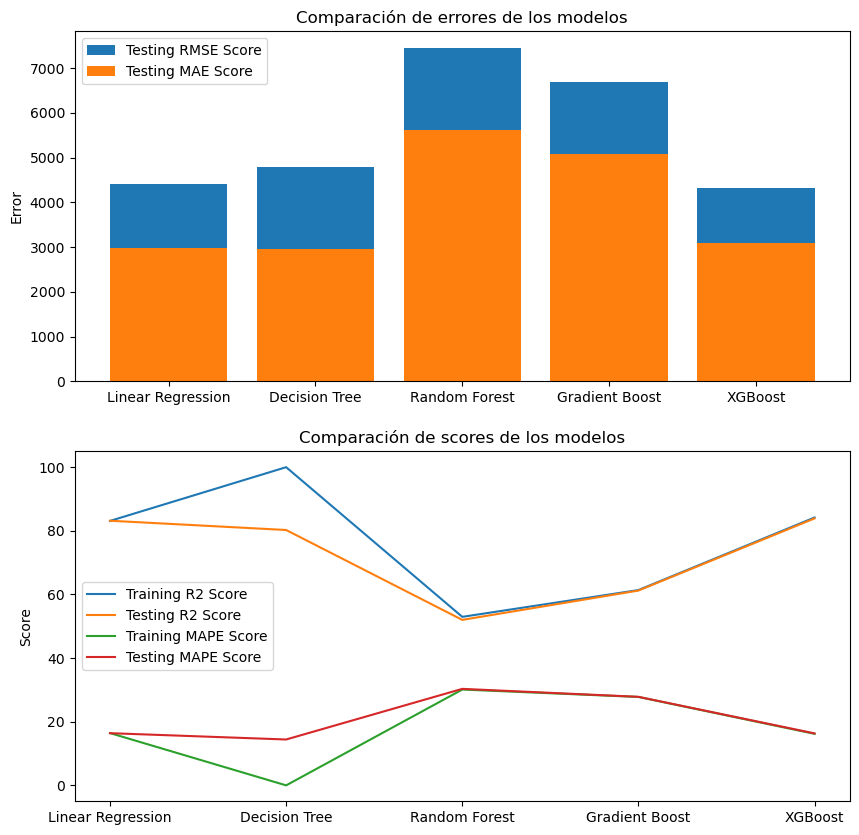

In [215]:

# Crear subplots para ambos gráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Gráfico de barras para RMSE y MAE
ax1.bar(df_resultados["Modelo"], df_resultados["Testing RMSE Score"], label="Testing RMSE Score")
ax1.bar(df_resultados["Modelo"], df_resultados["Testing MAE Score"], label="Testing MAE Score")
ax1.set_ylabel("Error")
ax1.set_title("Comparación de errores de los modelos")
ax1.legend()

# Gráfico de líneas para R2 y MAPE
ax2.plot(df_resultados["Modelo"], df_resultados["Training R2 Score"], label="Training R2 Score")
ax2.plot(df_resultados["Modelo"], df_resultados["Testing R2 Score"], label="Testing R2 Score")
ax2.plot(df_resultados["Modelo"], df_resultados["Training MAPE Score"], label="Training MAPE Score")
ax2.plot(df_resultados["Modelo"], df_resultados["Testing MAPE Score"], label="Testing MAPE Score")
ax2.set_ylabel("Score")
ax2.set_title("Comparación de scores de los modelos")
ax2.legend()

# Mostrar el gráfico
plt.show()

# Ajuste de hiperparámetros del modelo

Partiendo de los resultados de cada uno de los modelos, se van a ajustar hiperparámetros sobre el modelo GradientBoostingRegressor para validar el modelo

In [13]:

# Se definen los hiperparámetros a utilizar dentro del ajuste 
param_grid = {
    'learning_rate': [0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10, 20, 30]
}

# Crear un modelo Gradient Boosting Regressor
gb = GradientBoostingRegressor()

# Realizar una búsqueda de cuadrícula para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, verbose=2)
grid_search.fit(X_train_transformed, y_train)

# Imprimir los mejores hiperparámetros y la puntuación de validación cruzada
print("Mejores hiperparámetros: ", grid_search.best_params_)
print("Puntuación de validación cruzada: ", grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=  35.9s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=  36.1s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=  35.1s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=  35.2s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=  35.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time= 1.2min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time= 1.2min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time= 1.2min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time= 1.2min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time= 1.2min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time= 2.3min
[CV] END ...learning_rate=0.1, max_depth=3, n_es

## Análisis del resultado del ajuste de hiperparámetros

Una vez se ha ejecutado el ajuste de hiperparámetros se tiene el siguiente resultado:

* learning_rate = 0.1
* max_depth = 20
* n_estimators = 200

Para definir los hiperparámetros se utilizo el valor de learning_rate igual a 0.1, que indica la contibución de cada arbol al modelo final un parámetro bajo evita el sobreajuste del modelo, mas que todo el objetivo era iterar las combinaciones con los parámetros max_depth y n_estimators.

# Predicción con los mejores hiperparámetros 

In [169]:

gb_tunnig = GradientBoostingRegressor(learning_rate=0.1, max_depth=20, n_estimators=200)
gb_tunnig.fit(X_train_transformed, y_train)
y_pred = gb_tunnig.predict(X_test_transformed)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE para Gradient Boosting:", rmse)

RMSE para Gradient Boosting: 3679.318406541379


In [170]:
y_pred_gb_tunnig = gb_tunnig.predict(X_Testing_transformed)
submission_a = pd.DataFrame(y_pred_gb_tunnig)
submission_a.to_csv('test_submission_gb_tunnig.csv', index_label='ID')
submission_a.head()

,0
0,21718.783692
1,36808.394693
2,21820.968233
3,7847.944501
4,30217.898470
